In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling
from scipy import stats
import matplotlib.font_manager
import pyod
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
import random
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import time

# Loading Dataset

data = pd.read_csv("churn.csv")
print("Data shape:--> ",data.shape)

Data shape:-->  (7043, 21)


#  Understanding the Data and  Performing Data Manipulation 

In [2]:
pandas_profiling.ProfileReport(data)

In [3]:
data.replace(('No','Yes'),(0,1), inplace = True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce') 
data['TotalCharges'].fillna(data['TotalCharges'].mode()[0], inplace = True)
data.replace(('Electronic check','Mailed check','Bank transfer (automatic)','Credit card (automatic)'),(2,1,1,1), inplace = True)
data.replace(('One year','Two year','Month-to-month'),(2,3,1), inplace = True)
data.replace(('0','1','No internet service'),(3,2,1),inplace = True)
data.replace(('0','1','No phone service'),(2,3,1), inplace = True)
data.replace(('Fiber optic','DSL','0'),(3,2,1), inplace = True)
data['InternetService'] = pd.to_numeric(data['InternetService'])

# Data Visualization

In [4]:
data["Churn"].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

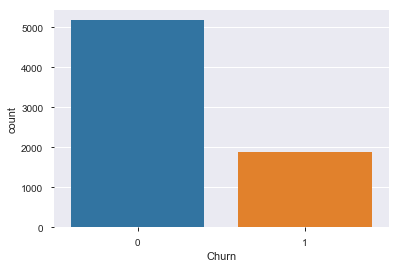

In [5]:
sns.countplot(x = "Churn",data = data)

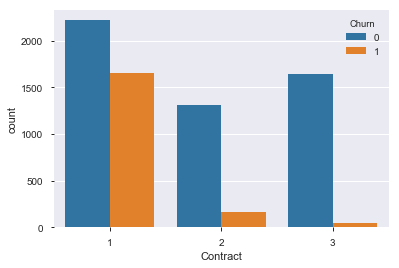

In [6]:
sns.countplot(x = "Contract", hue = "Churn", data = data)

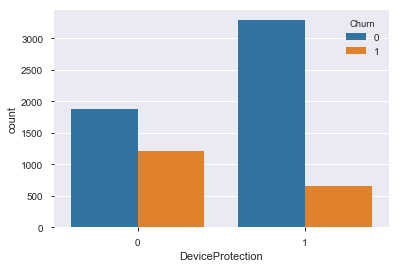

In [7]:
sns.countplot(x = "DeviceProtection", hue= "Churn", data = data)

Text(0.5, 1.0, 'Monthly Charges')

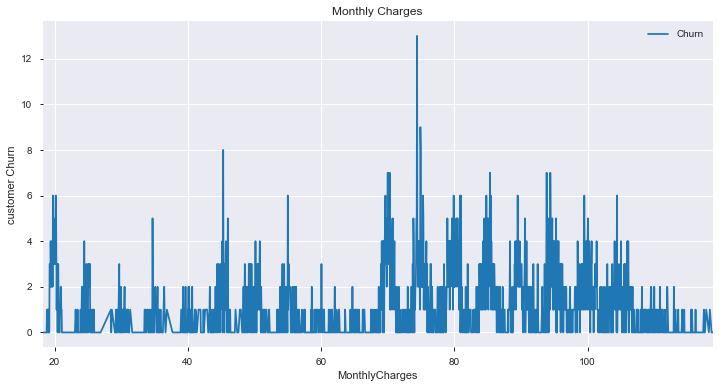

In [8]:
data.groupby("MonthlyCharges").agg({"Churn":"sum"}).plot(figsize = (12,6))
plt.ylabel("customer Churn")
plt.title("Monthly Charges")

Text(0.5, 1.0, 'Monthly Charges')

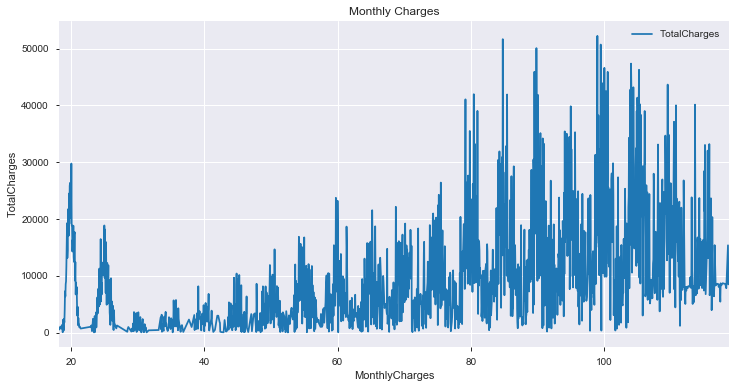

In [9]:
data.groupby("MonthlyCharges").agg({"TotalCharges":"sum"}).plot(figsize = (12,6))
plt.ylabel("TotalCharges")
plt.title("Monthly Charges")

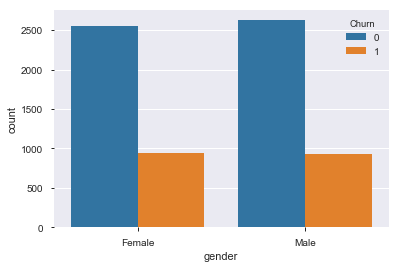

In [10]:
sns.countplot(x = "gender", hue = "Churn", data = data)

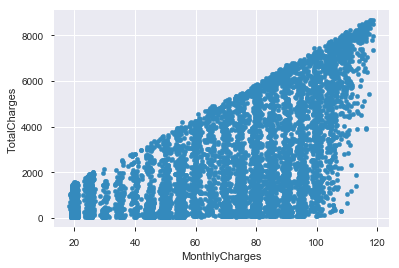

In [11]:
data.plot.scatter("MonthlyCharges","TotalCharges")

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
data[['MonthlyCharges','TotalCharges']] = scaler.fit_transform(data[['MonthlyCharges','TotalCharges']])
data[['MonthlyCharges','TotalCharges']].head()

MonthlyCharges  TotalCharges
0        0.115423      0.001275
1        0.385075      0.215867
2        0.354229      0.010310
3        0.239303      0.210241
4        0.521891      0.015330

In [13]:
X1 = data['MonthlyCharges'].values.reshape(-1,1)
X2 = data['TotalCharges'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)
random_state = np.random.RandomState(42)
outliers_fraction = 0.05
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction)
}

OUTLIERS :  0 INLIERS :  7043 Angle-based Outlier Detector (ABOD)


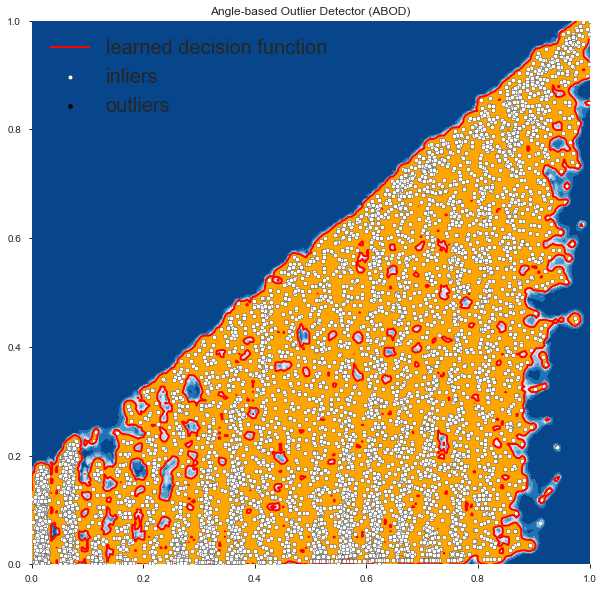

OUTLIERS :  353 INLIERS :  6690 Cluster-based Local Outlier Factor (CBLOF)


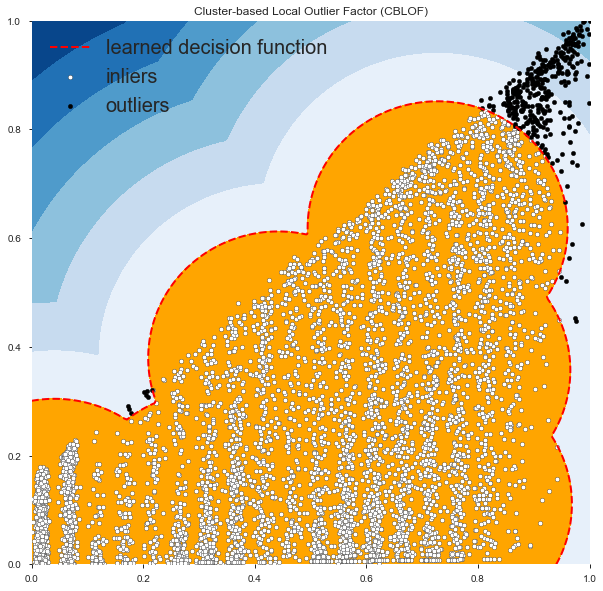

OUTLIERS :  297 INLIERS :  6746 Feature Bagging


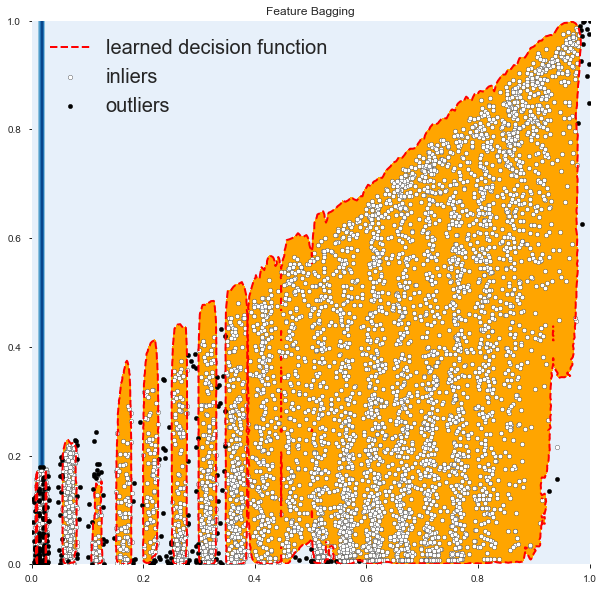

OUTLIERS :  309 INLIERS :  6734 Histogram-base Outlier Detection (HBOS)


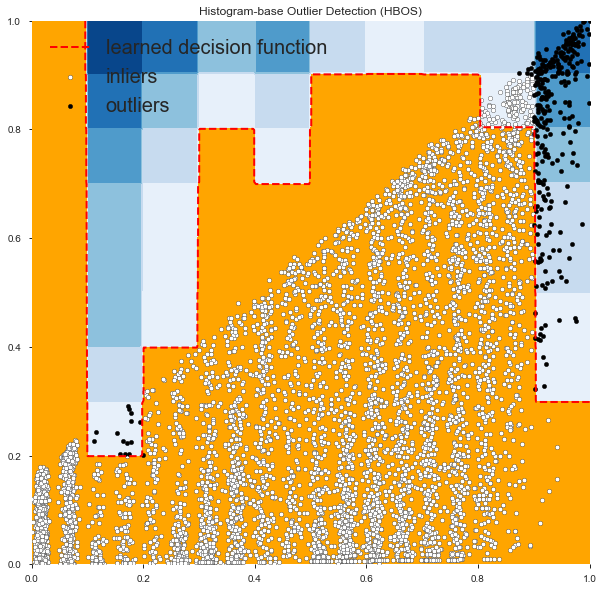

OUTLIERS :  353 INLIERS :  6690 Isolation Forest


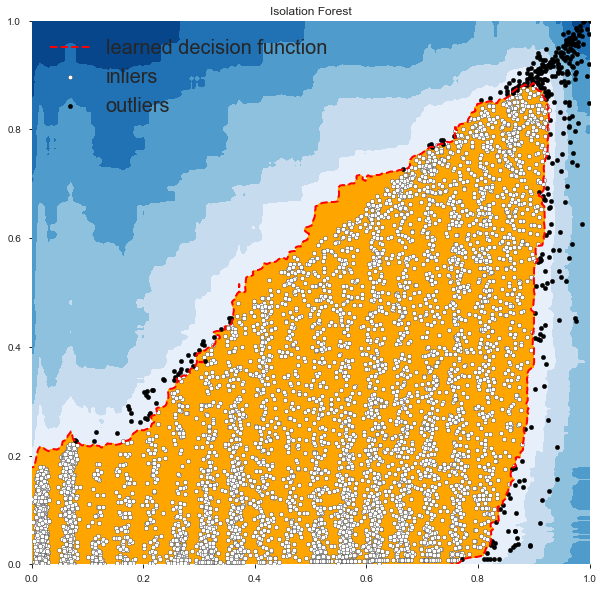

OUTLIERS :  223 INLIERS :  6820 K Nearest Neighbors (KNN)


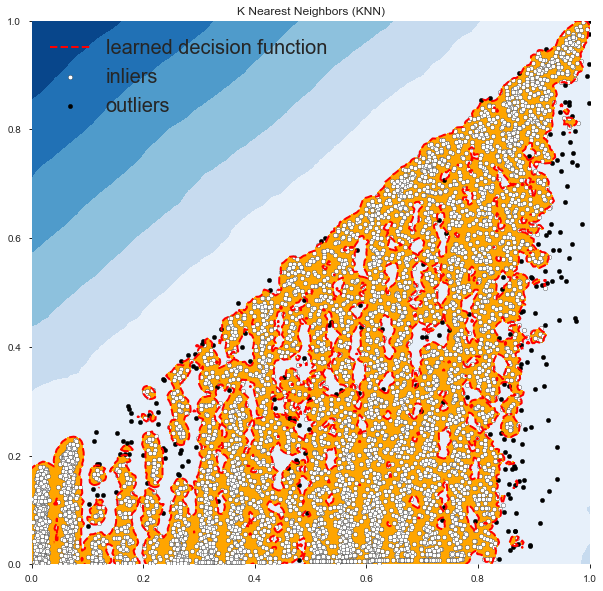

OUTLIERS :  83 INLIERS :  6960 Average KNN


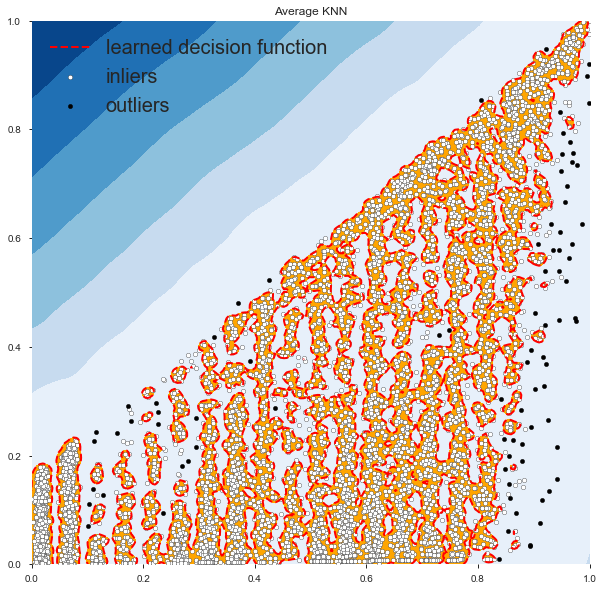

In [14]:
xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(X)
    # predict raw anomaly score
    scores_pred = clf.decision_function(X) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(X)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    
    # copy of dataframe
    dfx = data
    dfx['outlier'] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(dfx['MonthlyCharges'][dfx['outlier'] == 0]).reshape(-1,1)
    IX2 =  np.array(dfx['TotalCharges'][dfx['outlier'] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  dfx['MonthlyCharges'][dfx['outlier'] == 1].values.reshape(-1,1)
    OX2 =  dfx['TotalCharges'][dfx['outlier'] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
        
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
          
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    plt.axis('tight')  
    
    # loc=2 is used for the top left corner 
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.title(clf_name)
    plt.show()

We are checking if there are any outliers present in our dataset, i am checking in only two variables. It is not necessary that
always outliers are always bad. Few times outliers lead to new discoveries. There are many other approaches also available to check outliers like we can use Standard Deviation also.

# Feature Engineering

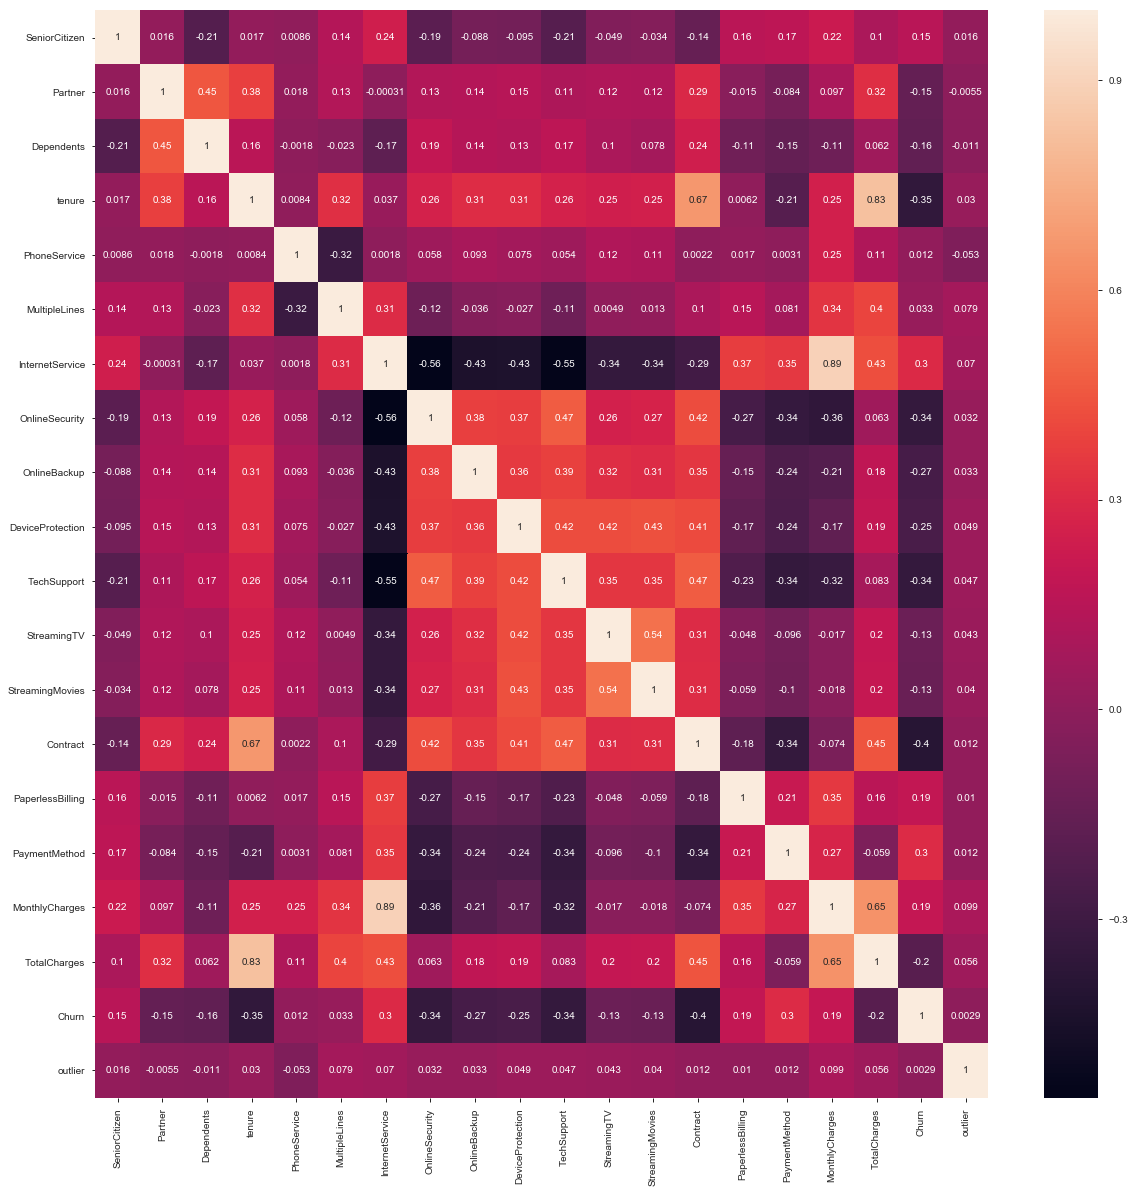

In [15]:
# Finding the co-relation and plotting a heatmap diagram
cormat = data.corr()
top_corr_features = cormat.index
plt.figure(figsize = (20,20))
#Plot heatmap
sns.heatmap(data[top_corr_features].corr(), annot = True)

In [16]:
corelation = data.corr()['Churn'].sort_values()
corelation

Contract           -0.396713
tenure             -0.352229
OnlineSecurity     -0.342637
TechSupport        -0.337281
OnlineBackup       -0.268005
DeviceProtection   -0.252481
TotalCharges       -0.198335
Dependents         -0.164221
Partner            -0.150448
StreamingMovies    -0.130845
StreamingTV        -0.128916
outlier             0.002903
PhoneService        0.011942
MultipleLines       0.032569
SeniorCitizen       0.150889
PaperlessBilling    0.191825
MonthlyCharges      0.193356
InternetService     0.298059
PaymentMethod       0.301919
Churn               1.000000
Name: Churn, dtype: float64

In [17]:
train_majority = data[data.Churn == 0]
train_minority = data[data.Churn == 1]
# Upsample minority Class
train_minority_upsampled = resample(train_minority,replace = True,n_samples = 5174,random_state = 123)
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority,train_minority_upsampled])
#Display New Class Counts
train_upsampled.Churn.value_counts()

1    5174
0    5174
Name: Churn, dtype: int64

In [18]:
data.drop(columns = "gender", axis = 1, inplace = True)

In [19]:
data.dtypes

customerID           object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
outlier               int64
dtype: object

In [20]:
X_train,X_test,y_train,y_test = train_test_split(train_upsampled.drop(['customerID','Churn'],axis = 1),
                                                  train_upsampled.Churn,test_size = 0.4320,random_state = 0)

In [25]:
# Applying SelectKbest class to extract 10 most best features
#bestfeatures = SelectKBest(score_func = chi2,k=5)
#fit = bestfeatures.fit(X_train,y_train)
#ValueError: could not convert string to float: 'Female
X_train.dtypes

gender               object
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
outlier               int64
dtype: object

In [26]:
X_train.drop(columns = "gender", axis = 1, inplace = True)

In [27]:
X_test.drop(columns = "gender", axis = 1, inplace = True)

In [28]:
bestfeatures = SelectKBest(score_func = chi2,k=10)
fit = bestfeatures.fit(X_train,y_train)

In [29]:
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#Concat two DataFrame for better Visualization
Featurescore = pd.concat([dfcolumns,dfscores], axis = 1)
Featurescore.columns = ['Specs','Scores'] # Naming the dataframe columns
print(Featurescore.nlargest(10,'Scores')) # Print 8 best Feature scores

               Specs        Scores
3             tenure  22324.425074
7     OnlineSecurity    626.489368
13          Contract    580.745859
10       TechSupport    546.146223
6    InternetService    407.426433
8       OnlineBackup    291.047472
9   DeviceProtection    260.951219
2         Dependents    151.984492
0      SeniorCitizen    142.133671
1            Partner    127.180552


In [30]:
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [31]:
print(model.feature_importances_) # use inbuilt class feature importances of tree based classifier

[0.02517033 0.02979182 0.0251792  0.13855309 0.00766303 0.02678809
 0.03031269 0.08707512 0.03581388 0.02684339 0.05879133 0.02332425
 0.02121828 0.11762892 0.03092299 0.04395685 0.12524121 0.1419825
 0.00374304]


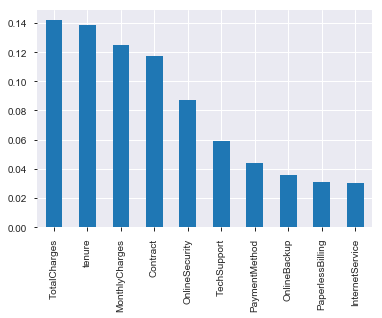

In [32]:
# plot grpah of feature importnaces for better visualization
feat_importances = pd.Series(model.feature_importances_, index = X_train.columns)
feat_importances.nlargest(10).plot(kind = 'bar')
plt.show()

# HyperParameter Tuning 

In [33]:
max_depth = [15,30,60,120]
min_samples_leaf = [3,15,25,45]
max_features = ['auto','sqrt']
param_grid = dict(max_depth = max_depth, min_samples_leaf = min_samples_leaf,max_features = max_features)
D_T = DecisionTreeClassifier()
grid = GridSearchCV(estimator = D_T,param_grid = param_grid, cv = 3)
start_time = time.time()
grid_result = grid.fit(X_train,y_train)

In [34]:
print("Best: %f using %s" %(grid_result.best_score_,grid_result.best_params_))

Best: 0.765356 using {'max_depth': 120, 'max_features': 'sqrt', 'min_samples_leaf': 15}


In [35]:
print("Execution Time:"+str((time.time()-start_time))+'ms')

Execution Time:20.62465476989746ms


In [36]:
# Number of trees in random Forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 300,num = 5)]
# Number of features consider at every split  split
max_features = ['auto','sqrt']
# Maximum number of level in tree
max_depth = [int (x) for x in np.linspace(10,110,num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,5,10]
# Minimum number of samples required at leaf node
min_samples_leaf = [1,4,10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 150, 200, 250, 300], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 35, 60, 85, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 4, 10], 'bootstrap': [True, False]}


In [37]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 15, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 2 folds for each of 15 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.5s finished


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [38]:
rf_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': False}

In [40]:
forest = RandomForestClassifier(n_estimators = 250,min_samples_split = 5,min_samples_leaf = 1,
                                max_features = 'auto',max_depth = 10,bootstrap = False)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
Rndom_score = round(forest.score(X_train,y_train)*100,2)
Rndom_score

91.48

In [42]:
score = cross_val_score(forest,X_train,y_train,cv = 7)
score.mean()

0.8325634051670268

In [43]:
y_pred_f = forest.predict(X_test)

In [44]:
roc_auc_score(y_test,y_pred_f)

0.8411950881175573

In [45]:
tree = DecisionTreeClassifier(max_depth = 120,max_features = 'sqrt',min_samples_leaf = 3)
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=120,
                       max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [46]:
tree_score = round(tree.score(X_train,y_train)*100,2)
tree_score

88.31

In [47]:
score = cross_val_score(tree,X_train,y_train,cv = 7)
score.mean()

0.7646748139008209

In [48]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.07, n_estimators=1000, 
                      min_child_weight=0.01, colsample_bytree=0.5, random_state=0)

lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='auc',
         early_stopping_rounds=100,
         verbose=100)

y_pred = lgbm.predict_proba(X_test)[:,-1]

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.878492	valid_0's binary_logloss: 0.432849
[200]	valid_0's auc: 0.890045	valid_0's binary_logloss: 0.412068
[300]	valid_0's auc: 0.899856	valid_0's binary_logloss: 0.396301
[400]	valid_0's auc: 0.905147	valid_0's binary_logloss: 0.388956
[500]	valid_0's auc: 0.90937	valid_0's binary_logloss: 0.383923
[600]	valid_0's auc: 0.912599	valid_0's binary_logloss: 0.381627
[700]	valid_0's auc: 0.914871	valid_0's binary_logloss: 0.381237
Early stopping, best iteration is:
[621]	valid_0's auc: 0.913322	valid_0's binary_logloss: 0.380745


# Conclusion

In [49]:
# As I am using roc_auc and accuracy score model to check accuracy of my model. We can use other methods also. 
#As clearly lgbm classifier  is our best method

In [50]:
# key factors that predict customer churn  are as follows: --->
#3             tenure  22324.425074
#7     OnlineSecurity    626.489368
#13          Contract    580.745859
#10       TechSupport    546.146223
#6    InternetService    407.426433
#8       OnlineBackup    291.047472
#9   DeviceProtection    260.951219
#2         Dependents    151.984492
#0      SeniorCitizen    142.133671
#1            Partner    127.180552

# Partner and Senior Citizen do not make any sense, which are not shown as a key feature in Extratreeclassifier method.

In [51]:
# Offers should be made to which customers to encourage them to remain with company 
# We can provide them contract for longer duration with good offers as we see those customer who are contracted for longer period
# they churn very less in numbers
# We can provide them Device Protection also because those customers who have Device Protection they also stay with company
# For Longer period of duration time
# We can provide them onlineBackup, OnlineSecurity, techsupport, InternetService with combo offers that they are cheaper and
# provide good quality servies to our customer.

In [52]:
# Assuming these actions were implemented, how would you determine whether they had worked?
# We keep checking our dataset so that whether customer have interest still on these offers, we customer start churn after
# some time we can provide them new offers according to customer interest and market sentiment.

In [ ]:
# Question 2 is answer above in comment section when we are visualizing outliers. We can select variable according our feature
# Engineering which i perform in above section. As there are no missing values present if there are missing values present
# we can deal with them using techniques like mean, medain and even droppping such rows. There are several other techniques
# also we can use them. 